count only questions:
- missing bid-ask spreads
- zero volumes
- missing implied volas
- implied volas above threshold
- prices below no arbitrage bound
- 

always:
- divide in calls / puts (-> in the money and out of the money work differently)
- use several moneyness indicators

- the purpose of this script is to show how some properties of the data behave locally

In [1]:
using Gadfly
using Econometrics

In [2]:
@time include("../startup_script2.jl")

elapsed time: 0.700485725 seconds (53053632 bytes allocated, 12.82% gc time)
elapsed time: 62.719431851 seconds (5419744236 bytes allocated, 62.56% gc time)
elapsed time: 0.892469077 seconds (112671656 bytes allocated, 45.73% gc time)
elapsed time: 76.970454066 seconds (5419744236 bytes allocated, 69.23% gc time)
elapsed time: 156.34406764 seconds (14680992612 bytes allocated, 61.48% gc time)
elapsed time: 88.95777955 seconds (5419744236 bytes allocated, 73.46% gc time)
elapsed time: 98.017234178 seconds (5419744236 bytes allocated, 76.34% gc time)
elapsed time: 376.60466517 seconds (30274866580 bytes allocated, 66.55% gc time)


6x3 DataFrame
| Row | Date       | ID                | IV |
|-----|------------|-------------------|----|
| 1   | 2006-07-03 | "c_20060721_4500" | NA |
| 2   | 2006-07-04 | "c_20060721_4500" | NA |
| 3   | 2006-07-05 | "c_20060721_4500" | NA |
| 4   | 2006-07-06 | "c_20060721_4500" | NA |
| 5   | 2006-07-07 | "c_20060721_4500" | NA |
| 6   | 2006-07-10 | "c_20060721_4500" | NA |

- still missing:
    - delta open interest
    - price inconsistencies: lower arbitrage bounds exceeded

In [3]:
locData = join(addObs, mnyness, on = [:Date, :ID]) |>
x -> join(x, impliedVolas, on = [:Date, :ID]) |>
x -> join(x, opts, on = :ID) |>
x -> join(x, cohortParams, on = [:Date, :Expiry]);

names(locData)

6x18 DataFrame
| Row | Date       | ID                | Bid | Ask | Volume | Open_Interest |
|-----|------------|-------------------|-----|-----|--------|---------------|
| 1   | 2006-07-03 | "c_20060721_4500" | NA  | NA  | 0      | 127           |
| 2   | 2006-07-03 | "c_20060721_4600" | NA  | NA  | 0      | 235           |
| 3   | 2006-07-03 | "c_20060721_4700" | NA  | NA  | 0      | 212           |
| 4   | 2006-07-03 | "c_20060721_4800" | NA  | NA  | 0      | 2749          |
| 5   | 2006-07-03 | "c_20060721_4850" | NA  | NA  | 0      | 122           |
| 6   | 2006-07-03 | "c_20060721_4900" | NA  | NA  | 0      | 413           |

| Row | AbsMny  | SimpMny | InvMny   | LogMny   | LogFMny  | SclMny   | IV |
|-----|---------|---------|----------|----------|----------|----------|----|
| 1   | 1212.69 | 1.26949 | 0.78772  | 0.238613 | 0.240167 | 1.01836  | NA |
| 2   | 1112.69 | 1.24189 | 0.805225 | 0.216634 | 0.218188 | 0.924554 | NA |
| 3   | 1012.69 | 1.21547 | 0.82273  | 0.195128 | 0.196682 | 0.832769 | NA |
| 4   | 912.69  | 1.19014 | 0.840235 | 0.174074 | 0.175628 | 0.742917 | NA |
| 5   | 862.69  | 1.17787 | 0.848987 | 0.163711 | 0.165266 | 0.69869  | NA |
| 6   | 812.69  | 1.16586 | 0.85774  | 0.153455 | 0.155009 | 0.654917 | NA |

| Row | Expiry     | Strike | IsCall | EONIA_matched | Time_to_Maturity |
|-----|------------|--------|--------|---------------|------------------|
| 1   | 2006-07-21 | 4500   | true   | 0.0283102     | 0.054902         |
| 2   | 2006-07-21 | 4600   | true   | 0.0283102     | 0.054902         |
| 3   | 2006-07-21 | 4700   | true   | 0.0283102     | 0.054902         |
| 4   | 2006-07-21 | 4800   | true   | 0.0283102     | 0.054902         |
| 5   | 2006-07-21 | 4850   | true   | 0.0283102     | 0.054902         |
| 6   | 2006-07-21 | 4900   | true   | 0.0283102     | 0.054902         |

- transform time to maturity:

In [4]:
days_to_mat = round(locData[:Time_to_Maturity]*255)
locData[:Days_to_Maturity] = days_to_mat;

In [5]:
function getEdges(da::DataArray, nBins::Int)
    return linspace(floor(minimum(dropna(da))), ceil(maximum(dropna(da))), nBins)
end

getEdges (generic function with 1 method)

In [14]:
xCol = :Days_to_Maturity
xEdges = getEdges(locData[:Days_to_Maturity], 100)

mnynessVals = [:AbsMny; :SimpMny; :InvMny; :LogMny; :LogFMny; :SclMny]
mnynessTtles = ["Absolute moneyness";
    "Simple moneyness";
    "Simple put moneyness";
    "Log moneyness";
    "Log Future moneyness";
    "Scaled moneyness"]

function countObs(df::SubDataFrame)
    return size(df, 1)
end

function countRelVolZeros(df::SubDataFrame)
    inds = convert(Array, df[:Volume] .== 0, false)
    return sum(inds)/size(df, 1)
end

function countRelMissIV(df::SubDataFrame)
    inds = isna(df[:IV])
    return sum(inds)/size(df, 1)
end

function countRelMissBid(df::SubDataFrame)
    inds = isna(df[:Bid]) 
    return sum(inds)/size(df, 1)
end

function countRelMissAsk(df::SubDataFrame)
    inds = isna(df[:Ask])
    return sum(inds)/size(df, 1)
end

function avgOI(df::SubDataFrame)
    return mean(df[:Open_Interest])
end

infoFuncs = Array(Function, 6)
infoFuncs[1] = countObs
infoFuncs[2] = countRelVolZeros
infoFuncs[3] = countRelMissIV
infoFuncs[4] = countRelMissBid
infoFuncs[5] = countRelMissAsk
infoFuncs[6] = avgOI

funcNames = ["Number observations";
    "Zero volume frequency";
    "Missing IV frequency";
    "Missing Bid frequency";
    "Missing Ask frequency";
    "Average open interest"]

dataSet = ["Both"; "Calls"; "Puts"]

3-element Array{ASCIIString,1}:
 "Both" 
 "Calls"
 "Puts" 

In [ ]:
for ll=1:length(dataSet)
    if dataSet[ll] == "Both"
        currData = locData
    elseif dataSet[ll] == "Calls"
        currData = locData[locData[:IsCall], :]
    else
        currData = locData[!locData[:IsCall], :]
    end
    
    for ii=1:length(mnynessVals)
        yCol = mnynessVals[ii]
        yEdges = getEdges(locData[yCol], 100)
    
        for kk=1:length(infoFuncs) 
            ttle = string(dataSet[ll], ": ", funcNames[kk])
            nam = string(replace(funcNames[kk], " ", "_"), "_",  string(yCol), "_", dataSet[ll])
            f = infoFuncs[kk]
            currPlot = plotLocalProperties(currData, xCol, yCol, xEdges, yEdges, f, xlab="Days to maturity", 
            ylab=mnynessTtles[ii], ttl = ttle) 
            
            draw(PNG("../pics/$nam.png", 20cm, 14cm), currPlot)
            #draw(SVG("../pics/$nam.svg", 20cm, 14cm), currPlot)
            #draw(PDF("../pics/$nam.pdf", 20cm, 14cm), currPlot)
        end
    end
end

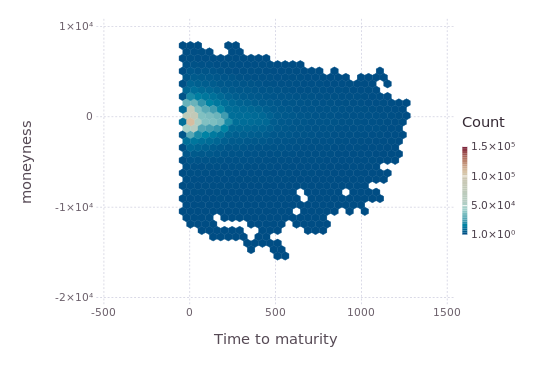

In [13]:
currPlot = Gadfly.plot(locData, x=xCol, y=yCol, Geom.hexbin(xbincount=50, ybincount=50),
Guide.xlabel("Time to maturity"), Guide.ylabel("moneyness"))

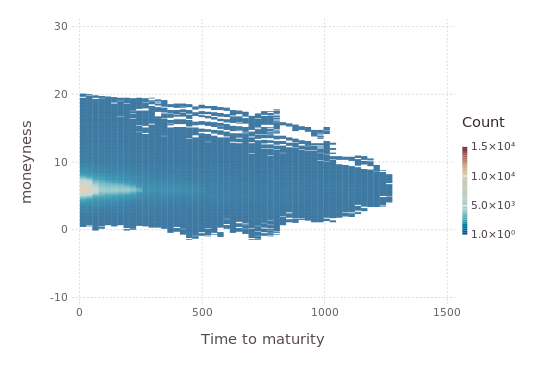

In [32]:
currPlot = Gadfly.plot(locData, x=xCol, y=yCol, Geom.histogram2d(xbincount=50, ybincount=250),
Guide.xlabel("Time to maturity"), Guide.ylabel("moneyness"))

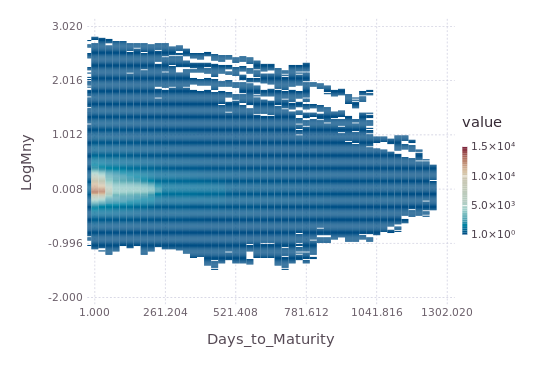

In [33]:
currPlot = plotLocalProperties(locData, xCol, yCol, xEdges, yEdges, countObs)

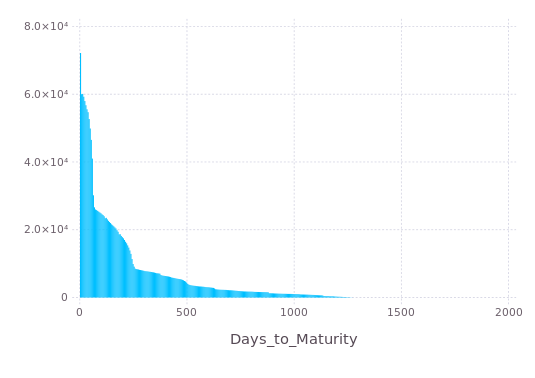

In [42]:
plot(locData, x=:Days_to_Maturity, Geom.histogram(bincount=300))

In [ ]:
currPlot = plotLocalProperties(locData[locData[:IsCall], :], xCol, yCol, xEdges, yEdges, countObs)

In [ ]:
currPlot = plotLocalProperties(locData[!locData[:IsCall], :], xCol, yCol, xEdges, yEdges, countObs)

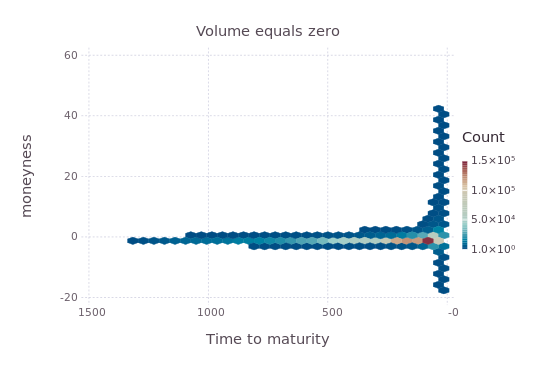

In [25]:
mnynessCol = :SclMny
ttmCol = :Days_to_Maturity

obsInd = locData[:Volume] .== 0
obsInd = convert(Array, obsInd, false)

smallData = locData[obsInd, [mnynessCol, ttmCol]]

currPlot = Gadfly.plot(smallData, x=ttmCol, y=mnynessCol, Geom.hexbin(xbincount=50, ybincount=50),
Scale.x_continuous(labels=x -> @sprintf("%6.0f", -x), maxvalue = 0),
Scale.y_continuous(labels=x -> @sprintf("%6.0f", x)),
Guide.xlabel("Time to maturity"), Guide.ylabel("moneyness"), Guide.title("Volume equals zero"))

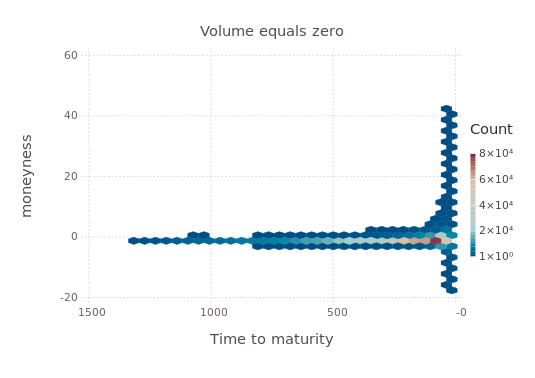

In [26]:
smallData = locData[obsInd, [mnynessCol, ttmCol, :IsCall]]
smallData = smallData[smallData[:IsCall], :]

currPlot = Gadfly.plot(smallData, x=ttmCol, y=mnynessCol, Geom.hexbin(xbincount=50, ybincount=50),
Scale.x_continuous(labels=x -> @sprintf("%6.0f", -x), maxvalue = 0),
Scale.y_continuous(labels=x -> @sprintf("%6.0f", x)),
Guide.xlabel("Time to maturity"), Guide.ylabel("moneyness"), Guide.title("Volume equals zero"))

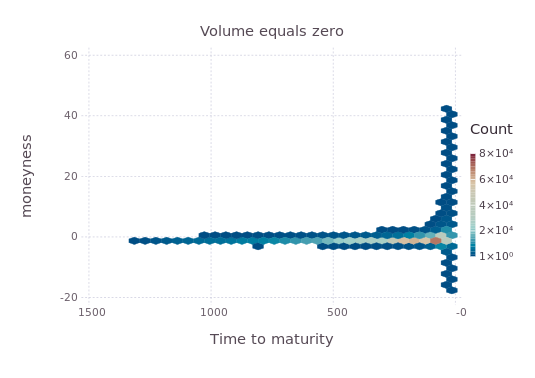

In [27]:
smallData = locData[obsInd, [mnynessCol, ttmCol, :IsCall]]
smallData = smallData[!smallData[:IsCall], :]

currPlot = Gadfly.plot(smallData, x=ttmCol, y=mnynessCol, Geom.hexbin(xbincount=50, ybincount=50),
Scale.x_continuous(labels=x -> @sprintf("%6.0f", -x), maxvalue = 0),
Scale.y_continuous(labels=x -> @sprintf("%6.0f", x)),
Guide.xlabel("Time to maturity"), Guide.ylabel("moneyness"), Guide.title("Volume equals zero"))

In [ ]:
draw(SVG("../pics/put_prices_below_bound.svg", 20cm, 14cm), currPlot)
draw(PDF("../pics/put_prices_below_bound.pdf", 20cm, 14cm), currPlot)

- define function to evaluate local properties

- where are observations?

In [39]:
xEdges = [0:0.5:6]
yEdges = Float64[-15000:500:9000]

xCol = :Time_to_Maturity
yCol = :AbsMny

function countObs(df::SubDataFrame)
    return size(df, 1)
end

countObs (generic function with 1 method)

In [31]:
using Gadfly

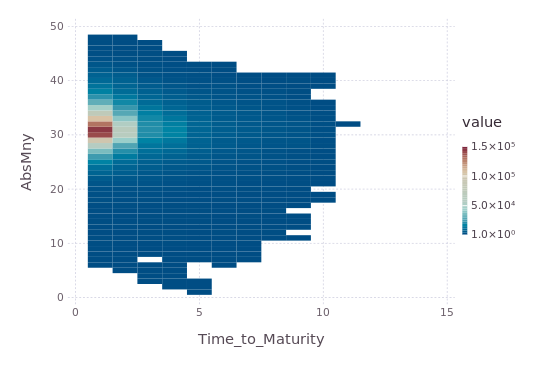

In [41]:
plot(res, x=xCol, y=yCol, color=:value, Geom.rectbin)

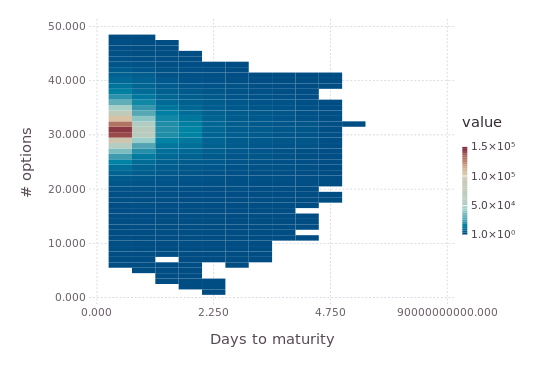

In [83]:
currPlot = Gadfly.plot(res, x=xCol, y=yCol, color=:value, Geom.rectbin,
Scale.x_continuous(labels=x -> @sprintf("%2.3f", xMidsFunc2(int(x))), minvalue=1, maxvalue=15),
Scale.y_continuous(labels=x -> @sprintf("%2.3f", x)),
Guide.xlabel("Days to maturity"),
Guide.ylabel("# options"))

In [33]:
eltypes(res)

3-element Array{Type{T<:Top},1}:
 Float64
 Float64
 Int64  

In [12]:
# Gadfly.plot(fullData, x="Time_to_Maturity", y="mnyness", Geom.hexbin(xbincount=100, ybincount=100))

In [14]:
# Gadfly.plot(fullData, x="Time_to_Maturity", y="mnyness", Geom.histogram2d)

In [15]:
# Gadfly.plot(fullData, x="Time_to_Maturity", y="mnyness", Stat.histogram2d(xbincount = 50, ybincount = 50), Geom.rectbin)